<a href="https://colab.research.google.com/github/adarsh-meher/MH-WPPH/blob/main/WPPH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
data = files.upload()

Saving Test.csv to Test.csv
Saving Train.csv to Train.csv


In [5]:
!pip install geocoder
!pip install geopy
!pip install catboost
!pip install hyperopt
!pip install shap
!pip install category_encoders
!pip install mlxtend
!pip install xgboost

     |████████████████████████████████| 102kB 3.5MB/s 
     |████████████████████████████████| 67.3MB 87kB/s 
     |████████████████████████████████| 358kB 5.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491628 sha256=f0c18faf72baab2a47c671758656b9b52623f8419f6fbb28ebaa136d466f378f
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 81kB 3.5MB/s 


In [6]:
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import time
import io
import re
import nltk
import string
import warnings
warnings.filterwarnings('ignore')

In [7]:
train = pd.read_csv(io.BytesIO(data['Train.csv']))
test = pd.read_csv(io.BytesIO(data['Test.csv']))

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Uniq Id                     21000 non-null  object 
 1   Package Name                21000 non-null  object 
 2   Package Type                21000 non-null  object 
 3   Destination                 21000 non-null  object 
 4   Itinerary                   21000 non-null  object 
 5   Places Covered              21000 non-null  object 
 6   Travel Date                 21000 non-null  object 
 7   Hotel Details               21000 non-null  object 
 8   Start City                  21000 non-null  object 
 9   Airline                     21000 non-null  object 
 10  Flight Stops                21000 non-null  int64  
 11  Meals                       21000 non-null  int64  
 12  Sightseeing Places Covered  21000 non-null  object 
 13  Cancellation Rules          210

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Uniq Id                     9000 non-null   object
 1   Package Name                9000 non-null   object
 2   Package Type                9000 non-null   object
 3   Destination                 9000 non-null   object
 4   Itinerary                   9000 non-null   object
 5   Places Covered              9000 non-null   object
 6   Travel Date                 9000 non-null   object
 7   Hotel Details               9000 non-null   object
 8   Start City                  9000 non-null   object
 9   Airline                     9000 non-null   object
 10  Flight Stops                9000 non-null   int64 
 11  Meals                       9000 non-null   int64 
 12  Sightseeing Places Covered  9000 non-null   object
 13  Cancellation Rules          9000 non-null   obje

In [10]:
############
train.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0


# EDA

## Target distribution and plot

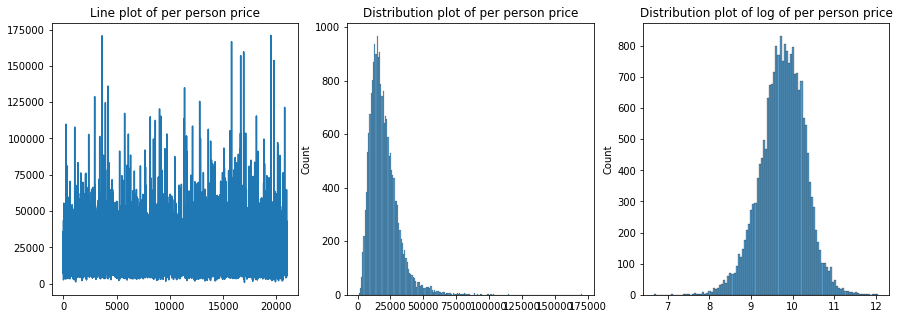

In [11]:
target = train['Per Person Price'].values
fig,axs = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))

axs[0].plot(target)
#sb.lineplot(y = target,ax=axs[0])
axs[0].set_title('Line plot of per person price')

sb.histplot(target,ax=axs[1])
axs[1].set_title('Distribution plot of per person price')

sb.histplot(np.log(target),ax = axs[2])
axs[2].set_title('Distribution plot of log of per person price')

plt.show()

## Package Type vs Target Prices

In [12]:
################ Value proportion of package type in train/test. Assuming Budget < Standard < Deluxe < Premium < Luxury
train['Package Type'].value_counts()/train.shape[0]

Deluxe      0.286000
Standard    0.269952
Premium     0.265762
Luxury      0.156095
Budget      0.022190
Name: Package Type, dtype: float64

In [13]:
test['Package Type'].value_counts()/test.shape[0]

Standard    0.278000
Deluxe      0.277000
Premium     0.264333
Luxury      0.156667
Budget      0.024000
Name: Package Type, dtype: float64

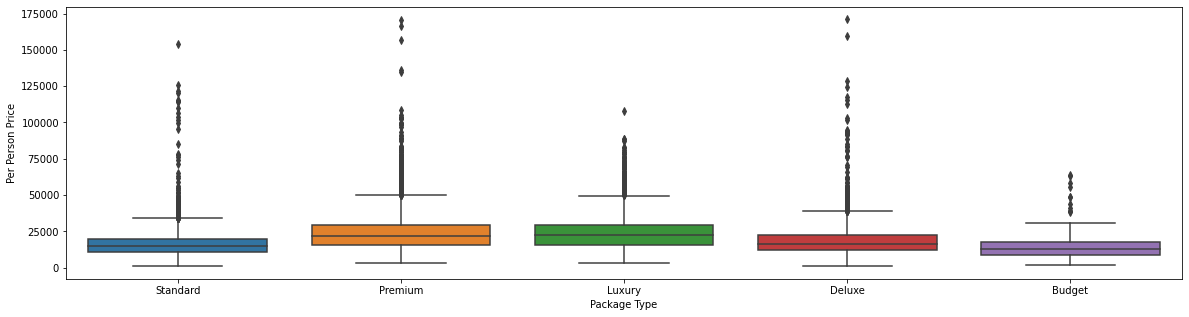

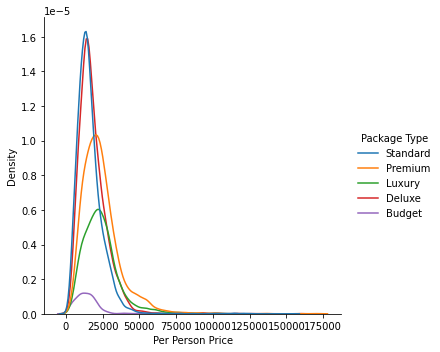

In [14]:
plt.figure(figsize = (20,5))
sb.boxplot(data = train,y='Per Person Price',x = 'Package Type')
sb.displot( train,x = 'Per Person Price',hue = 'Package Type',kind = 'kde')
plt.show()

 Feature info : Create summary variables like : Mean / Min / Max / Percentiles

Analyzing Places Covered

In [15]:
train.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0


In [16]:
########################### Get list of places covered for each row
train['places_cover_list'] = train['Places Covered'].map(lambda x : list(set(x.split('|'))))
test['places_cover_list'] = test['Places Covered'].map(lambda x : list(set(x.split('|'))))
places_cov_train = list(set([ j for i in train['places_cover_list'].values for j in i ]))
places_cov_test = list(set([ j for i in test['places_cover_list'].values for j in i ]))

train['Places Covered'].nunique(),len(places_cov_train),len(places_cov_test),len(set(places_cov_test).difference(places_cov_train))

(565, 182, 180, 1)

In [17]:
train.groupby(['Places Covered'])['Per Person Price'].agg(Mean = np.mean,Min = np.min,Max = np.max).reset_index()

,Places Covered,Mean,Min,Max
0,Abu Dhabi,28037.462963,21879.5,37374.0
1,Abu Dhabi|Dubai,37957.875000,31626.5,45408.5
2,Agra,3997.173077,2846.0,11101.0
3,Agra|Bharatpur|Jaipur|Nawalgarh|Jodhpur|Jaisal...,43669.333333,31591.0,78421.5
4,Agra|Gwalior|Orchha|Khajuraho,24258.000000,24258.0,24258.0
...,...,...,...,...
560,Udaipur|Pali,16951.555556,9217.5,22899.5
561,Udaipur|Ranakpur|Chittorgarh,16557.600000,13559.5,23154.5
562,Varkala|Kovalam,14628.454545,9732.5,18866.0
563,Wayanad,9944.602564,791.0,23295.5


In [18]:
#################### Concatenating package type with places covered to see how prices differ across different packages and places
train['pkg_type_places_cov'] = train[['Package Type','places_cover_list']].apply(lambda x : [ '_'.join([x[0],i]) for i in x[1] ] ,axis = 1)
test['pkg_type_places_cov'] = test[['Package Type','places_cover_list']].apply(lambda x : [ '_'.join([x[0],i]) for i in x[1] ] ,axis = 1)
pkg_type_places_train = list(set([ j for i in train['pkg_type_places_cov'].values for j in i]))
pkg_type_places_test = list(set([ j for i in test['pkg_type_places_cov'].values for j in i]))
len(pkg_type_places_test),len(pkg_type_places_train),len(set(pkg_type_places_test).intersection(pkg_type_places_train))

(632, 670, 617)

In [19]:
######################## Prices for each package type and place covered
test['Per Person Price'] = [0.]*test.shape[0]
pkg_place_price_tr = train[['pkg_type_places_cov','Per Person Price']].apply(lambda x : ['/'.join([i,str(x[1])]) for i in x[0]] ,axis = 1)
pkg_place_price_test = test[['pkg_type_places_cov','Per Person Price']].apply(lambda x : ['/'.join([i,str(x[1])]) for i in x[0]] ,axis = 1)
pkg_place_price_tr = [ j for i in pkg_place_price_tr for j in i]
pkg_place_price_test = [ j for i in pkg_place_price_test for j in i]
pkg_place_price_tr = pd.DataFrame({'Pkg_Place' : [ i.split('/')[0] for i in pkg_place_price_tr],'Price' : [ float(i.split('/')[1]) for i in pkg_place_price_tr]},
                               index = range(len(pkg_place_price_tr)))
pkg_place_price_test = pd.DataFrame({'Pkg_Place' : [ i.split('/')[0] for i in pkg_place_price_test],'Price' : [ float(i.split('/')[1]) for i in pkg_place_price_test]},
                               index = range(len(pkg_place_price_test)))

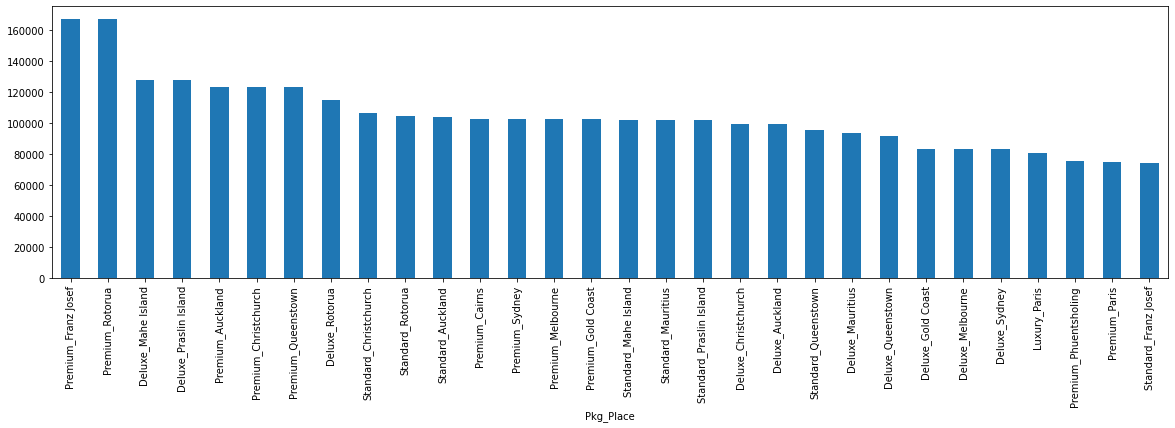

In [20]:
pkg_place_price_tr.groupby(['Pkg_Place'])['Price'].agg(np.nanmean).sort_values(ascending = False)[:30].plot.bar(figsize = (20,5))

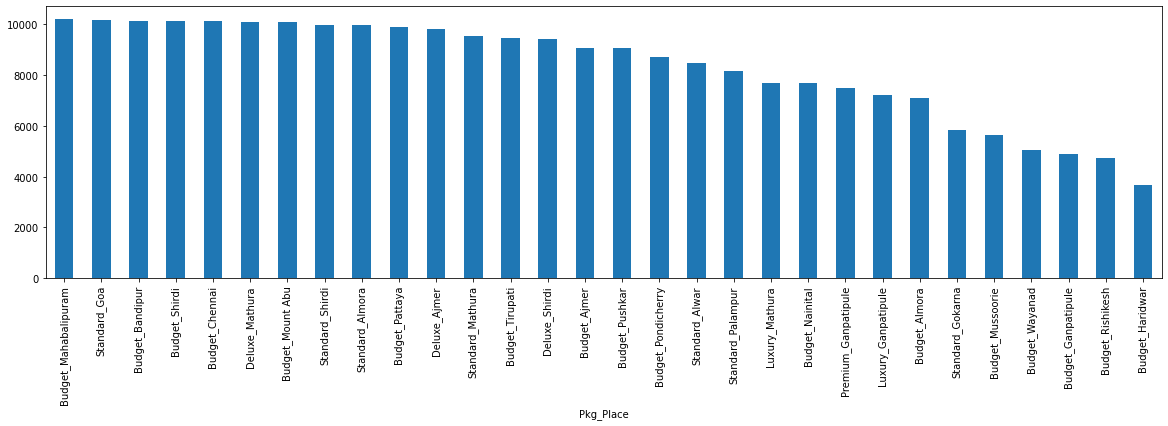

In [21]:
pkg_place_price_tr.groupby(['Pkg_Place'])['Price'].agg(np.nanmean).sort_values(ascending = False)[-30:].plot(kind = 'bar',figsize = (20,5))

In [22]:
pkg_place = pd.concat([pkg_place_price_tr['Pkg_Place'],pkg_place_price_test['Pkg_Place']],axis = 0)
pkg_place = pkg_place.drop_duplicates().to_frame()
pkg_place['place'] = pkg_place['Pkg_Place'].map(lambda x: x.split('_')[1])
pkg_place['Package'] = pkg_place['Pkg_Place'].map(lambda x: x.split('_')[0])

In [23]:
pkg_place.head()

,Pkg_Place,place,Package
0,Standard_Chandigarh,Chandigarh,Standard
1,Standard_Manali,Manali,Standard
2,Standard_New Delhi,New Delhi,Standard
3,Standard_Shimla,Shimla,Standard
4,Premium_Srinagar,Srinagar,Premium


In [24]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(timeout=3)
pkg_place['country'] = 'NA'
pkg_place['place_type'] = 'NA'
for p in pkg_place.place.unique().tolist(): 
  #print('place : ',p)
  try:
    location = geolocator.geocode(p.lower(),language='en')
    loc_dict = location.raw
    #print(loc_dict['display_name'])
    #print(loc_dict['display_name'].rsplit(',' , 1)[1])
  except AttributeError:
    pkg_place.loc[pkg_place.place == p,'country'] = p.lower()

  try:
    pkg_place.loc[pkg_place.place == p,'country'] = loc_dict['display_name'].rsplit(',' , 1)[1].lower()
  except:
    pkg_place.loc[pkg_place.place == p,'country'] = loc_dict['display_name'].lower()
  
  pkg_place.loc[pkg_place.place == p,'place_type'] = loc_dict['type'].lower()

In [25]:
######################### additional changes.
pkg_place.loc[pkg_place.place == 'Bali','place_type'] = 'island'
pkg_place.loc[pkg_place.place == 'Bali','country'] = 'indonesia'
pkg_place.loc[pkg_place.place_type == 'hotel','place_type'] = 'city'
pkg_place.loc[pkg_place.place_type == 'primary','place_type'] = 'town'
pkg_place.loc[pkg_place.place_type == 'municipality','place_type'] = 'city'
pkg_place.loc[pkg_place.place_type == 'restaurant','place_type'] = 'town'
pkg_place.loc[pkg_place.place_type == 'traffic_signals','place_type'] = 'river'
pkg_place.loc[pkg_place.place_type == 'fuel','place_type'] = 'island'
pkg_place.loc[pkg_place.place_type == 'fuel','country'] = 'india'
pkg_place.loc[pkg_place.place_type == 'islet','place_type'] = 'island'
pkg_place.loc[pkg_place.place_type == 'bus_stop','place_type'] = 'town'
pkg_place.loc[pkg_place.place_type == 'industrial','place_type'] = 'city'
pkg_place.loc[pkg_place.place_type == 'county','place_type'] = 'town'
pkg_place.loc[pkg_place.place_type == 'yes','place_type'] = 'cruise'
pkg_place = pkg_place[pkg_place.place_type != 'secondary']
pkg_place['country'] = pkg_place['country'].map(lambda x: ''.join(x.strip().split()))

In [26]:
place_cnty_dict = { i.place.lower():i.country for i in pkg_place[['place','country']].itertuples(index = False) }
place_type_dict = { i.place.lower():i.place_type for i in pkg_place[['place','place_type']].itertuples(index = False) }

## Airline / Flight Stops vs Target Price

In [27]:
######################## Unique airlines and their proportion
print('Number of unique airlines : ',train.Airline.nunique())
np.cumsum((train.Airline.value_counts()/train.shape[0]*100).sort_values(ascending = False)[:20])

Number of unique airlines :  314


Not Available                                                              23.380952
IndiGo                                                                     40.938095
Spicejet                                                                   55.623810
Go Air                                                                     65.819048
IndiGo|IndiGo                                                              71.138095
Spicejet|Spicejet                                                          75.485714
Vistara                                                                    78.247619
Air India                                                                  80.680952
IndiGo|IndiGo|IndiGo|IndiGo                                                82.847619
IndiGo|Spicejet                                                            84.585714
Spicejet|IndiGo                                                            85.733333
Go Air|IndiGo                                                    

In [28]:
############################### Extract unique airlines and number of airlies at each row. Concatenate multiple airlines and airlines with start city.
train['airplane_list'] = train['Airline'].map(lambda x : list(set(x.lower().split('|'))))
train['num_airplane'] = train['airplane_list'].map(lambda x : -1 if x[0]=='not available' else len(x))
train['airplanes'] = train['airplane_list'].map(lambda x : x[0] if len(x)==1 else '_'.join(sorted(x)))

test['airplane_list'] = test['Airline'].map(lambda x : list(set(x.lower().split('|'))))
test['num_airplane'] = test['airplane_list'].map(lambda x : -1 if x[0]=='not available' else len(x))
test['airplanes'] = test['airplane_list'].map(lambda x : x[0] if len(x)==1 else '_'.join(sorted(x)))

In [29]:
train['airplanes'].nunique()

176

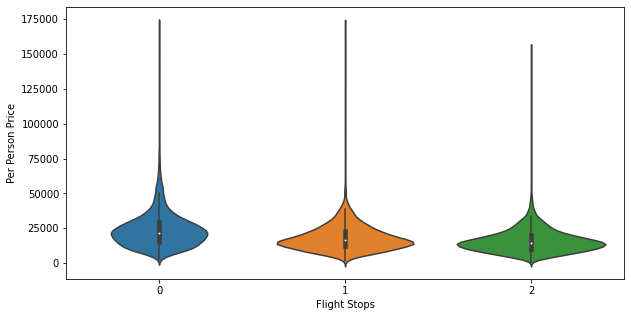

In [30]:
############################# Distribution plot of flight stops vs target prices
plt.figure(figsize = (10,5))
sb.violinplot(data = train,x = 'Flight Stops',y = 'Per Person Price')
plt.show()

In [31]:
train_airplanes = []
test_airplanes = []
for i in train.airplane_list.values:
  for j in i:
    train_airplanes.append(j)
train_airplanes = set(train_airplanes)

for i in test.airplane_list.values:
  for j in i:
    test_airplanes.append(j)
test_airplanes = set(test_airplanes)

len(train_airplanes),len(test_airplanes),len(test_airplanes.difference(train_airplanes))

(56, 40, 0)

Feature Info : Try to create OHE of 56 variable with 1's at places where the airplanes appear

## Assessing Hotel Details

In [32]:
from wordcloud import WordCloud

In [33]:
hotel_det = train['Hotel Details'].values

In [34]:
################ proportion of values where hotel details are not available
hotel_det.shape,round(sum(hotel_det=='Not Available')/hotel_det.shape[0]*100,2)

((21000,), 13.95)

In [35]:
hotel_det = hotel_det[hotel_det!='Not Available']

In [36]:
hotel_det

array(['The Orchard Retreat & Spa:4.6|WelcomHotel Pine N Peak Pahalgam - Member ITC Hotel Group:4.1|The Orchard Retreat & Spa:4.6',
       'The Ananta:4.4|juSTa Lake Nahargarh Palace:4',
       'Elixir Hills Suites Resort & Spa-MMT Holidays Special:4.6|The Zuri Kumarakom, Kerala Resort & Spa:4.6|Marari Beach - CGH Earth:4.3|Estuary Sarovar Portico:',
       ..., 'Mount Lavinia Hotel-MMT HOLIDAYS SPECIAL:4.0',
       'Ramada by Wyndham Darjeeling Gandhi Road:4.4|The Aryan Regency:3.7|Lemon Tree Hotel  Gangtok:4.2',
       'Iceberg Hill Hotel-MMT Holidays Special:3.8|Sagara Beach Resort - MMT Holidays Special:|Hotel Royale Park:'],
      dtype=object)

In [37]:
from nltk.corpus import stopwords
nltk.download('stopwords')

sw = stopwords.words('english')
def hotel_det_clean(x):
  texts = [ i.split(':')[0] for i in x.lower().split('|')]
  texts = [ i.encode('ascii','ignore').decode() for i in texts ]
  texts = [ re.sub('[%s]' % re.escape(string.punctuation),' ',i)  for i in texts]
  texts = [ re.sub(r'\w*\d+\w*', '', i) for i in texts ]
  texts = [ ' '.join(i.split()) for i in texts]
  return texts

hotel_det_texts = [ hotel_det_clean(i) for i in hotel_det ]
hotel_det_texts = [ j for i in hotel_det_texts for j in i]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


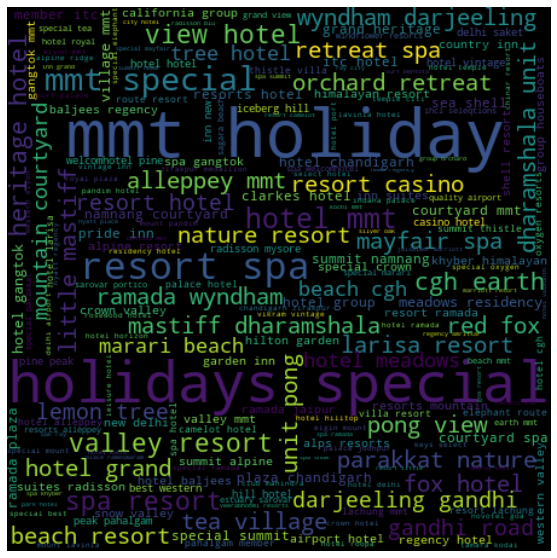

In [38]:
# Create the wordcloud object
wordcloud = WordCloud(width=450, height=450, margin=0).generate('.'.join(hotel_det_texts))

# Display the generated image:
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

############### keywords to extract : resort,spa,mmt,holidays,specials,hotel

In [39]:
########################## Extract average rating from hotels details 
map_word_to_num = {'zero':0,'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7,'eight':8,'nine':9}
def conv_to_num(x):
  try:
    return float(x)
  except:
    return map_word_to_num[x]

def extract_price(x):
  t = [ i.split(':')[-1] for i in x.split('|') ]
  t = [ conv_to_num(i)  for i in t if i!='']
  return t

train['avg_hotel_rtng'] =train['Hotel Details'].map(lambda x : round(np.mean(extract_price(x.lower())),1) if x!='Not Available' else -1) 
test['avg_hotel_rtng'] =test['Hotel Details'].map(lambda x : round(np.mean(extract_price(x.lower())),1) if x!='Not Available' else -1) 

Feature Info :  Average rating from hotel review. Selected some words from wordcloud that appear prominently. 

## Feature Engineering / Model Training

In [40]:
train.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,places_cover_list,pkg_type_places_cov,airplane_list,num_airplane,airplanes,avg_hotel_rtng
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,"[Chandigarh, Manali, New Delhi, Shimla]","[Standard_Chandigarh, Standard_Manali, Standar...",[not available],-1,not available,-1.0
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,"[Srinagar, Pahalgam]","[Premium_Srinagar, Premium_Pahalgam]",[indigo],1,indigo,4.4
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5,"[Udaipur, Chittorgarh]","[Luxury_Udaipur, Luxury_Chittorgarh]",[indigo],1,indigo,4.2
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0,"[Allepey, Kumarakom, Kovalam and Poovar, Munnar]","[Premium_Allepey, Premium_Kumarakom, Premium_K...",[indigo],1,indigo,4.5
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0,"[Pattaya, Bangkok]","[Premium_Pattaya, Premium_Bangkok]","[spicejet, go air]",2,go air_spicejet,4.4


In [41]:
####################### Converting package type into ordinal variables
pkg_type_int = {'Budget' : 1, 'Deluxe' : 3, 'Luxury' : 5, 'Premium' : 4, 'Standard' : 2}
train['pkg_type_int'] = train['Package Type'].map(lambda x : pkg_type_int[x])
test['pkg_type_int'] = test['Package Type'].map(lambda x : pkg_type_int[x])

In [42]:
####################### Creating OHE for places covered and implementing autoencoders over it
pkg_place['place'] = pkg_place['place'].map(lambda x : x.lower())
place_dummies = pd.get_dummies(pkg_place.drop(['Pkg_Place','country','place_type'],axis = 1),columns = ['place'])
place_dum_sing_row = place_dummies.iloc[0:1,:]
place_dum_sing_row.loc[0,:] = 0
train['places_cover_list'] = train['places_cover_list'].map(lambda x : [i.lower() for i in x])
place_cov_dum = pd.DataFrame(columns = place_dum_sing_row.columns.tolist())
for p in train.places_cover_list.values:
  t1 = [ 'place_'+i for i in p]
  place_dum_sing_row.loc[0,t1] = 1
  place_cov_dum = place_cov_dum.append(place_dum_sing_row,ignore_index = True)
  place_dum_sing_row.loc[0,:] = 0

train.shape,place_cov_dum.shape

((21000, 22), (21000, 183))

In [43]:
place_dum_sing_row.loc[0,:] = 0
test['places_cover_list'] = test['places_cover_list'].map(lambda x : [i.lower() for i in x])
place_cov_dum_test = pd.DataFrame(columns = place_dum_sing_row.columns.tolist())
for p in test.places_cover_list.values:
  t1 = [ 'place_'+i for i in p]
  place_dum_sing_row.loc[0,t1] = 1
  place_cov_dum_test = place_cov_dum_test.append(place_dum_sing_row,ignore_index = True)
  place_dum_sing_row.loc[0,:] = 0

place_cov_dum_test = place_cov_dum_test.iloc[:,:-1]
place_cov_dum_test = place_cov_dum_test.astype(float) 
test.shape,place_cov_dum_test.shape

((9000, 22), (9000, 183))

In [44]:
place_cov_dum = place_cov_dum.astype(float)

In [75]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
n_inputs = place_cov_dum.shape[1]
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = 5 #round(float(n_inputs) / 4.0)
bottleneck = Dense(n_bottleneck,activation='sigmoid')(e)
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='sigmoid')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy')
X_train, X_test, y_train, y_test = train_test_split(place_cov_dum, np.ones((place_cov_dum.shape[0],)), test_size=0.20, random_state=1993)
history = model.fit(X_train.values, X_train.values, epochs=50, batch_size=20, verbose=2, validation_data=(X_test.values,X_test.values))
encoder = Model(inputs=visible, outputs=bottleneck)

Epoch 1/50
840/840 - 6s - loss: 0.0309 - val_loss: 0.0090
Epoch 2/50
840/840 - 5s - loss: 0.0092 - val_loss: 0.0052
Epoch 3/50
840/840 - 5s - loss: 0.0067 - val_loss: 0.0039
Epoch 4/50
840/840 - 5s - loss: 0.0057 - val_loss: 0.0031
Epoch 5/50
840/840 - 5s - loss: 0.0048 - val_loss: 0.0022
Epoch 6/50
840/840 - 5s - loss: 0.0042 - val_loss: 0.0019
Epoch 7/50
840/840 - 5s - loss: 0.0039 - val_loss: 0.0019
Epoch 8/50
840/840 - 5s - loss: 0.0036 - val_loss: 0.0014
Epoch 9/50
840/840 - 5s - loss: 0.0029 - val_loss: 0.0012
Epoch 10/50
840/840 - 5s - loss: 0.0029 - val_loss: 0.0011
Epoch 11/50
840/840 - 5s - loss: 0.0028 - val_loss: 0.0013
Epoch 12/50
840/840 - 5s - loss: 0.0026 - val_loss: 0.0012
Epoch 13/50
840/840 - 5s - loss: 0.0025 - val_loss: 8.0135e-04
Epoch 14/50
840/840 - 5s - loss: 0.0021 - val_loss: 7.5924e-04
Epoch 15/50
840/840 - 5s - loss: 0.0022 - val_loss: 5.9352e-04
Epoch 16/50
840/840 - 5s - loss: 0.0020 - val_loss: 6.5561e-04
Epoch 17/50
840/840 - 5s - loss: 0.0021 - val_los

In [76]:
place_cov_dum_test = place_cov_dum_test.astype(float) 
place_cov_enc = encoder.predict(place_cov_dum)
place_cov_test_enc = encoder.predict(place_cov_dum_test)
place_cov_enc.shape,place_cov_test_enc.shape

((21000, 5), (9000, 5))

In [77]:
place_cov_enc = pd.DataFrame(place_cov_enc,columns = [ 'Place_Enc_'+str(i+1) for i in range(place_cov_enc.shape[1])])
place_cov_test_enc = pd.DataFrame(place_cov_test_enc,columns = [ 'Place_Enc_'+str(i+1) for i in range(place_cov_enc.shape[1])])
place_cov_enc.columns

Index(['Place_Enc_1', 'Place_Enc_2', 'Place_Enc_3', 'Place_Enc_4',
       'Place_Enc_5'],
      dtype='object')

In [48]:
################################# Map places to country and place type
train['place_country'] = train['places_cover_list'].map(lambda x : list(set([ place_cnty_dict[i.lower()] for i in x ]))[0] )
train['place_type'] = train['places_cover_list'].map(lambda x : list(set([ place_type_dict[i.lower()] for i in x ]))[0] )
test['place_country'] = test['places_cover_list'].map(lambda x : list(set([ place_cnty_dict[i.lower()] if i!='30-01-2021' else 'na' for i in x ]))[0] )
test['place_type'] = test['places_cover_list'].map(lambda x : list(set([ place_cnty_dict[i.lower()] if i!='30-01-2021' else 'na'  for i in x ]))[0] )

In [49]:
################################ Create dummy for the following keywords from hotel details : resort,spa,mmt,holidays,specials,hotel
keys = ['resort','spa','mmt','holidays','specials','hotel']
for k in keys:
  train['contain_'+k] = train['Hotel Details'].map(lambda x : 0 if x=='Not Available' else 1 if k in ' '.join(hotel_det_clean(x)) else 0 )
  test['contain_'+k] = test['Hotel Details'].map(lambda x : 0 if x=='Not Available' else 1 if k in ' '.join(hotel_det_clean(x)) else 0 )

In [50]:
train.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,places_cover_list,pkg_type_places_cov,airplane_list,num_airplane,airplanes,avg_hotel_rtng,pkg_type_int,place_country,place_type,contain_resort,contain_spa,contain_mmt,contain_holidays,contain_specials,contain_hotel
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,"[chandigarh, manali, new delhi, shimla]","[Standard_Chandigarh, Standard_Manali, Standar...",[not available],-1,not available,-1.0,2,india,administrative,0,0,0,0,0,0
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,"[srinagar, pahalgam]","[Premium_Srinagar, Premium_Pahalgam]",[indigo],1,indigo,4.4,4,india,administrative,0,1,0,0,0,1
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5,"[udaipur, chittorgarh]","[Luxury_Udaipur, Luxury_Chittorgarh]",[indigo],1,indigo,4.2,5,india,administrative,0,0,0,0,0,0
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0,"[allepey, kumarakom, kovalam and poovar, munnar]","[Premium_Allepey, Premium_Kumarakom, Premium_K...",[indigo],1,indigo,4.5,4,india,village,1,1,1,1,0,0
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0,"[pattaya, bangkok]","[Premium_Pattaya, Premium_Bangkok]","[spicejet, go air]",2,go air_spicejet,4.4,4,thailand,city,0,0,1,0,0,1


In [51]:
############################### Create date realted features
train['date_new'] = pd.to_datetime(train['Travel Date'],format = "%d-%m-%Y")
test['date_new'] = pd.to_datetime(test['Travel Date'],format = "%d-%m-%Y")

train['month'] = train.date_new.dt.month
train['day'] = train.date_new.dt.day
train['dayofyear'] = train.date_new.dt.dayofyear
train['weekday'] = train.date_new.dt.weekday
train['weekofyear'] = train.date_new.dt.weekofyear

test['month'] = test.date_new.dt.month
test['day'] = test.date_new.dt.day
test['dayofyear'] = test.date_new.dt.dayofyear
test['weekday'] = test.date_new.dt.weekday
test['weekofyear'] = test.date_new.dt.weekofyear

In [52]:
def calc_total_nights(x):
  num_days = []
  for i in x.split():
    try:
      num_days.append(int(i.split('N')[0]))
    except:
      continue
  return sum(num_days)

train['total_nights'] = train.Itinerary.map(lambda x: calc_total_nights(x))
test['total_nights'] = test.Itinerary.map(lambda x: calc_total_nights(x))

## Model Training / Testing

In [81]:
train.columns

Index(['Uniq Id', 'Package Name', 'Package Type', 'Destination', 'Itinerary',
       'Places Covered', 'Travel Date', 'Hotel Details', 'Start City',
       'Airline', 'Flight Stops', 'Meals', 'Sightseeing Places Covered',
       'Cancellation Rules', 'Per Person Price', 'places_cover_list',
       'pkg_type_places_cov', 'airplane_list', 'num_airplane', 'airplanes',
       'avg_hotel_rtng', 'pkg_type_int', 'place_country', 'place_type',
       'contain_resort', 'contain_spa', 'contain_mmt', 'contain_holidays',
       'contain_specials', 'contain_hotel', 'date_new', 'month', 'day',
       'dayofyear', 'weekday', 'weekofyear', 'total_nights', 'Place_Enc_1',
       'Place_Enc_2', 'Place_Enc_3', 'Place_Enc_4', 'Place_Enc_5'],
      dtype='object')

In [80]:
#train = train.drop(['Place_Enc_1','Place_Enc_2', 'Place_Enc_3'],axis = 1)
#test = test.drop(['Place_Enc_1','Place_Enc_2', 'Place_Enc_3'],axis = 1)
train = pd.concat([train,place_cov_enc],axis = 1)
test = pd.concat([test,place_cov_test_enc],axis = 1)

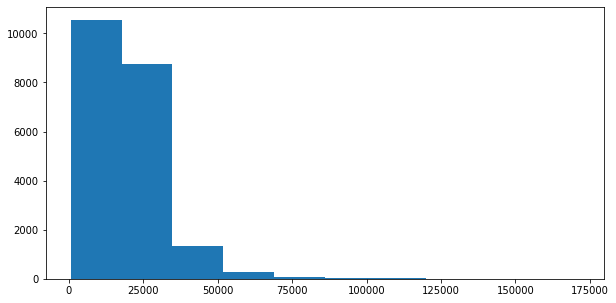

In [55]:
plt.figure(figsize = (10,5))
(_,bins,_) = plt.hist(train['Per Person Price'].values)
plt.show()

In [56]:
#################### Count of values in within bins 
bin_range = [ [bins[i],bins[i+1]] for i in range(len(bins)-1)]
bin_range = [[0,bins[0]]] + bin_range
for i in bin_range:
  t1 = train[(train['Per Person Price']>=i[0]) & (train['Per Person Price']<i[1])]
  print('Num samples in range  {0} : {1}'.format(i,t1.shape[0]))

Num samples in range  [0, 791.0] : 0
Num samples in range  [791.0, 17818.15] : 10545
Num samples in range  [17818.15, 34845.3] : 8731
Num samples in range  [34845.3, 51872.450000000004] : 1318
Num samples in range  [51872.450000000004, 68899.6] : 281
Num samples in range  [68899.6, 85926.75] : 69
Num samples in range  [85926.75, 102953.90000000001] : 28
Num samples in range  [102953.90000000001, 119981.05000000002] : 15
Num samples in range  [119981.05000000002, 137008.2] : 7
Num samples in range  [137008.2, 154035.35] : 1
Num samples in range  [154035.35, 171062.5] : 4


In [82]:
cat_cols = ['Package Type','Start City','place_country','place_type','airplanes','month','day','weekday']
num_cols = ['Flight Stops','Meals','num_airplane','avg_hotel_rtng'] +  ['total_nights'] + ['Place_Enc_1', 'Place_Enc_2', 'Place_Enc_3', 'Place_Enc_4','Place_Enc_5'] +['contain_'+i for i in keys]
target_col = 'Per Person Price'

In [83]:
from catboost import CatBoostRegressor, FeaturesData, Pool,cv
from sklearn.metrics import mean_squared_log_error,make_scorer
from sklearn.model_selection import GridSearchCV,cross_val_score,cross_val_predict

In [84]:
x_train,x_test,y_train,y_test = train_test_split(train.drop([target_col],axis = 1,),train[target_col].values,test_size = 0.2,shuffle = True,random_state = 1993)
x_train.index,x_test.index = range(x_train.shape[0]),range(x_test.shape[0])
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((16800, 41), (4200, 41), (16800,), (4200,))

In [85]:
train.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,places_cover_list,pkg_type_places_cov,airplane_list,num_airplane,airplanes,avg_hotel_rtng,pkg_type_int,place_country,place_type,contain_resort,contain_spa,contain_mmt,contain_holidays,contain_specials,contain_hotel,date_new,month,day,dayofyear,weekday,weekofyear,total_nights,Place_Enc_1,Place_Enc_2,Place_Enc_3,Place_Enc_4,Place_Enc_5
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,"[chandigarh, manali, new delhi, shimla]","[Standard_Chandigarh, Standard_Manali, Standar...",[not available],-1,not available,-1.0,2,india,administrative,0,0,0,0,0,0,2021-07-30,7,30,211,4,30,6,0.170520,0.080928,0.722200,0.462919,0.369351
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,"[srinagar, pahalgam]","[Premium_Srinagar, Premium_Pahalgam]",[indigo],1,indigo,4.4,4,india,administrative,0,1,0,0,0,1,2021-12-08,12,8,342,2,49,4,0.629969,0.135356,0.584114,0.664372,0.502308
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5,"[udaipur, chittorgarh]","[Luxury_Udaipur, Luxury_Chittorgarh]",[indigo],1,indigo,4.2,5,india,administrative,0,0,0,0,0,0,2021-04-26,4,26,116,0,17,3,0.542875,0.235993,0.556939,0.163507,0.298834
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0,"[allepey, kumarakom, kovalam and poovar, munnar]","[Premium_Allepey, Premium_Kumarakom, Premium_K...",[indigo],1,indigo,4.5,4,india,village,1,1,1,1,0,0,2021-08-27,8,27,239,4,34,6,0.257714,0.561663,0.256278,0.489041,0.613774
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0,"[pattaya, bangkok]","[Premium_Pattaya, Premium_Bangkok]","[spicejet, go air]",2,go air_spicejet,4.4,4,thailand,city,0,0,1,0,0,1,2021-12-12,12,12,346,6,49,7,0.551022,0.263272,0.561882,0.506723,0.374434


In [86]:
from sklearn.model_selection import KFold
kfold_cv = KFold(random_state = 1993,n_splits=5,shuffle = True)

In [87]:
import category_encoders as ce
ce_ohe = ce.one_hot.OneHotEncoder(cols = cat_cols,drop_invariant =True)
ce_count = ce.count.CountEncoder(cols = cat_cols,drop_invariant =True)
ce_loo = ce.leave_one_out.LeaveOneOutEncoder(cols = cat_cols,drop_invariant =True)
ce_te = ce.target_encoder.TargetEncoder(cols = cat_cols,drop_invariant =True)
ce_cat = ce.CatBoostEncoder(cols=cat_cols,drop_invariant=True)

In [88]:
from sklearn.linear_model import LinearRegression,ElasticNetCV,RidgeCV,LassoCV
from sklearn.feature_selection import SelectKBest,SelectFromModel,RFECV
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,ExtraTreesRegressor
from sklearn.linear_model import HuberRegressor,BayesianRidge
from mlxtend.regressor import StackingCVRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor,XGBRFRegressor

In [89]:
def rmsle_f(actual,pred):
  return np.sqrt(mean_squared_log_error(actual,pred))
rmsle_metric = make_scorer(rmsle_f,greater_is_better=False)

In [344]:
np.random.seed(1993)
k = 1
for train_index,test_index in kfold_cv.split(x_train):
  ind = train_index
  
  Xtrain,Xtest = x_train.loc[train_index,:],x_train.loc[test_index,:]
  print('Train/Test shape : {0} / {1}'.format(Xtrain.shape,Xtest.shape))
  Ytrain,Ytest = y_train[train_index],y_train[test_index]
  print("Starting training for fold : ",str(k))

  Xtrain = ce_cat.fit_transform(Xtrain[cat_cols + num_cols],Ytrain)
  Xtest = ce_cat.transform(Xtest[cat_cols + num_cols])
  #Xtrain = Xtrain[cat_cols + num_cols].fillna(0)
  #Xtest = Xtest[cat_cols + num_cols].fillna(0)
  Xtrain_val = Xtrain.fillna(0).values.astype(np.float)
  Xtest_val = Xtest.fillna(0).values.astype(np.float)
  min_train,max_train = min(Ytrain),max(Ytrain)

  elasnet = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1],cv = 3,random_state = 1993)
  lasso = LassoCV(alphas = [.1, .5, .7, .9, .95, .99, 1],cv = 3,random_state = 1993)
  huber = HuberRegressor(max_iter=500,alpha=0.01)
  linreg = LinearRegression()
  svreg = SVR(kernel='rbf',gamma = 'auto',C = 100)
  gbm = GradientBoostingRegressor(learning_rate = 0.001,n_estimators=500,min_samples_split = 5,min_samples_leaf = 5,max_depth = 8,random_state = 1993)
  rf = RandomForestRegressor(n_estimators = 500,max_depth = 8,min_samples_leaf = 5,min_samples_split = 5,random_state=1993)
  cboost = CatBoostRegressor( depth =  12.0,learning_rate = 0.0440937487494777,iterations=1000,border_count = 155,l2_leaf_reg = 15.873281420967894,
                          verbose = False,random_state = 1993)

  xgb_model = XGBRegressor(objective = 'reg:squarederror',colsample_bytree = 1.0,learning_rate = 0.01,max_depth = 8,min_child_weight = 1,
        n_estimators = 1000,subsample = 0.7,random_state = 1993)
  ml_stack = StackingCVRegressor(regressors=(xgb_model,cboost,gbm),
                            meta_regressor=xgb_model,store_train_meta_features = True,refit = True)
  ml_stack_fit = xgb_model.fit(Xtrain_val,Ytrain)
  y_test_pred = ml_stack_fit.predict(Xtest_val)
  #y_test_pred = [ min_train if i<min_train else max_train if i>max_train else i for i in y_test_pred ]
  scores = rmsle_f(Ytest,y_test_pred)

  print('RMSLE score : {0}'.format(scores))
  k = k+1


Train/Test shape : (13440, 41) / (3360, 41)
Starting training for fold :  1
RMSLE score : 0.20514301491808654
Train/Test shape : (13440, 41) / (3360, 41)
Starting training for fold :  2
RMSLE score : 0.2048197407227185
Train/Test shape : (13440, 41) / (3360, 41)
Starting training for fold :  3
RMSLE score : 0.19977160274079261
Train/Test shape : (13440, 41) / (3360, 41)
Starting training for fold :  4
RMSLE score : 0.2006702523911773
Train/Test shape : (13440, 41) / (3360, 41)
Starting training for fold :  5
RMSLE score : 0.19790074641462882


In [295]:
x_train = ce_te.fit_transform(x_train[cat_cols + num_cols],y_train)
x_test = ce_te.transform(x_test[cat_cols + num_cols])
x_train_val = x_train.fillna(0).values.astype(np.float)
x_test_val = x_test.fillna(0).values.astype(np.float)
min_train,max_train = min(y_train),max(y_train)
cboost = CatBoostRegressor( depth =  12.0,learning_rate = 0.0440937487494777,iterations=1000,border_count = 155,l2_leaf_reg = 15.873281420967894,
                          verbose = False,random_state = 1993)

cboost_fit = cboost.fit(x_train_val,y_train)
y_test_pred = cboost_fit.predict(x_test_val)
y_test_pred = [ min_train if i<min_train else max_train if i>max_train else i for i in y_test_pred ]
scores = rmsle_f(y_test,y_test_pred)
print('RMSLE : ',str(scores))

RMSLE :  0.19673625270975728


In [296]:
train1 = ce_te.fit_transform(train[cat_cols + num_cols],train[target_col])
test1 = ce_te.transform(test[cat_cols + num_cols])
train_val = train1.fillna(0).values.astype(np.float)
test_val = test1.fillna(0).values.astype(np.float)
min_train,max_train = min(train[target_col]),max(train[target_col])
cboost = CatBoostRegressor( depth =  12.0,learning_rate = 0.0440937487494777,iterations=1000,border_count = 155,l2_leaf_reg = 15.873281420967894,
                          verbose = False,random_state = 1993)

cboost_fit = cboost.fit(train_val,train[target_col])
preds = cboost_fit.predict(test_val)
preds = [ min_train if i<min_train else max_train if i>max_train else i for i in preds ]

In [298]:
preds = cboost_fit.predict(test_val)
preds = [ min_train if i<min_train else max_train if i>max_train else i for i in preds ]

In [299]:
len(preds)

9000

In [170]:
train_pool = Pool(
    data = FeaturesData(num_feature_data = np.array(train[num_cols].values, dtype=np.float32), 
                    cat_feature_data = np.array(train[cat_cols].values, dtype=object), 
                    num_feature_names = list(num_cols), 
                    cat_feature_names = list(cat_cols)),
    label =  np.array(train[target_col], dtype=np.float32)
)

Xtrain_pool = Pool(
    data = FeaturesData(num_feature_data = np.array(x_train[num_cols].values, dtype=np.float32), 
                    cat_feature_data = np.array(x_train[cat_cols].values, dtype=object), 
                    num_feature_names = list(num_cols), 
                    cat_feature_names = list(cat_cols)),
    label =  np.array(y_train, dtype=np.float32)
)
Xtest_pool = Pool(
    data = FeaturesData(num_feature_data = np.array(x_test[num_cols].values, dtype=np.float32), 
                    cat_feature_data = np.array(x_test[cat_cols].values, dtype=object), 
                    num_feature_names = list(num_cols), 
                    cat_feature_names = list(cat_cols)),
    label =  np.array(y_test, dtype=np.float32)
)

In [171]:
test_pool = Pool(
    data = FeaturesData(num_feature_data = np.array(test[num_cols].values, dtype=np.float32), 
                    cat_feature_data = np.array(test[cat_cols].values, dtype=object), 
                    num_feature_names = list(num_cols), 
                    cat_feature_names = list(cat_cols))
)

In [65]:
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest

In [66]:
def get_catboost_params(space):
    params = dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])
    params['l2_leaf_reg'] = space['l2_leaf_reg']
    params['border_count'] = int(space['border_count'])
    #params['eval_metric'] = RMSLEMetric()
    params['iterations'] = int(space['iterations'])
    #params['use_best_model'] = True
    #params['task_type'] = 'GPU'
    #params['early_stopping_rounds'] = 100
    params['verbose'] = False
    #params['loss_function'] = 'RMSE'
    params['random_state'] = 1993
    #params['rsm'] = space['rsm']
    return params

In [67]:
obj_call_count = 0
cur_best_loss = np.inf
log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

In [68]:
class RMSLEMetric(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        approxes = approxes[0]
        error_sum = 0.0
        weight_sum = 0.0
        n = len(approxes)
        
        for i in range(len(approxes)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((np.log(approxes[i]+1)-np.log(target[i]+1))**2)
        error = np.sqrt(error_sum/n)
        return error, weight_sum

In [72]:
def cboost_cv_run(x_train,y_train,params):
  kfold_cv = KFold(random_state = 1993,n_splits=5,shuffle = True)
  cboost_model = CatBoostRegressor(**params)
  cv_scores = []
  print('Starting to cross validate.')
  for train_index,test_index in kfold_cv.split(x_train):
    Xtrain,Xtest = x_train.loc[train_index,:],x_train.loc[test_index,:]
    Ytrain,Ytest = y_train[train_index],y_train[test_index]

    Xtrain = ce_cat.fit_transform(Xtrain[cat_cols + num_cols],Ytrain)
    Xtest = ce_cat.transform(Xtest[cat_cols + num_cols])
    Xtrain_val = Xtrain.fillna(0).values.astype(np.float)
    Xtest_val = Xtest.fillna(0).values.astype(np.float)
    min_train,max_train = min(Ytrain),max(Ytrain)
    
    ml_stack_fit = cboost_model.fit(Xtrain_val,Ytrain)
    y_test_pred = ml_stack_fit.predict(Xtest_val)
    y_test_pred = [ min_train if i<min_train else max_train if i>max_train else i for i in y_test_pred ]
    scores = rmsle_f(Ytest,y_test_pred)
    cv_scores.append(scores)
  print('Completed.')
  return np.mean(cv_scores)



In [73]:
def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )
    iters = params['iterations']
    #cv_model = cv(Xtrain_pool,params,fold_count = 5)
    #rmsle_loss = cv_model[cv_model['iterations'] == (iters-1)]['test-RMSLEMetric-mean'].values[0]
    rmsle_loss = cboost_cv_run(x_train,y_train,params)
    
    log_writer.write('loss={:<7.5f}  Params:{} \n'.format(rmsle_loss,params_str))
    log_writer.flush()

    if rmsle_loss<cur_best_loss:
        cur_best_loss = rmsle_loss
        print('NEW BEST LOSS={0}'.format(cur_best_loss))


    return{'loss':rmsle_loss, 'status': STATUS_OK }


In [91]:
space = {
        'depth': hp.quniform("depth", 4, 15, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.loguniform('learning_rate', -5.0, -2),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 20),
         'iterations' : hp.choice("iterations",[1000,2000,5000]),
         'ctr_border_count':hp.choice('ctr_border_count',[50,5,10,20,100,200])
}

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=20,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best )
print('\n\n')


CatBoost objective call #7 cur_best_loss=0.20936
Params: border_count=109.52936362535954 ctr_border_count=20 depth=7.0 iterations=2000 l2_leaf_reg=13.802905098556527 learning_rate=0.05444842323249136
Starting to cross validate.
Completed.
NEW BEST LOSS=0.20930773378393885

CatBoost objective call #8 cur_best_loss=0.20931
Params: border_count=239.63200629427539 ctr_border_count=50 depth=14.0 iterations=2000 l2_leaf_reg=4.693495411850011 learning_rate=0.009186178517596988
Starting to cross validate.
Completed.

CatBoost objective call #9 cur_best_loss=0.20931
Params: border_count=168.6225584930413 ctr_border_count=20 depth=8.0 iterations=2000 l2_leaf_reg=12.94472393305279 learning_rate=0.04151798222137169
Starting to cross validate.
Completed.

CatBoost objective call #10 cur_best_loss=0.20931
Params: border_count=196.8475765813659 ctr_border_count=100 depth=10.0 iterations=2000 l2_leaf_reg=19.005392056093715 learning_rate=0.05571629152972956
Starting to cross validate.
Completed.
NEW B

In [184]:
##################### Rerun model with best params on train and validate on test
model = CatBoostRegressor( depth =  12.0,learning_rate = 0.0440937487494777,iterations=1000,border_count = 155,l2_leaf_reg = 15.873281420967894,
                          verbose = True,random_state = 1993)
model.fit(Xtrain_pool)
preds = model.predict(Xtest_pool)

Streaming output truncated to the last 5000 lines.
5000:	learn: 2775.6147023	total: 10m 42s	remaining: 10m 41s
5001:	learn: 2775.5945482	total: 10m 42s	remaining: 10m 41s
5002:	learn: 2775.4554568	total: 10m 42s	remaining: 10m 41s
5003:	learn: 2775.3700446	total: 10m 42s	remaining: 10m 41s
5004:	learn: 2775.3475981	total: 10m 42s	remaining: 10m 41s
5005:	learn: 2775.1769415	total: 10m 42s	remaining: 10m 41s
5006:	learn: 2775.1184344	total: 10m 43s	remaining: 10m 41s
5007:	learn: 2774.8809933	total: 10m 43s	remaining: 10m 41s
5008:	learn: 2774.4752988	total: 10m 43s	remaining: 10m 41s
5009:	learn: 2774.0557344	total: 10m 43s	remaining: 10m 40s
5010:	learn: 2773.7866484	total: 10m 43s	remaining: 10m 40s
5011:	learn: 2773.2983944	total: 10m 43s	remaining: 10m 40s
5012:	learn: 2773.2471157	total: 10m 43s	remaining: 10m 40s
5013:	learn: 2773.2110640	total: 10m 43s	remaining: 10m 40s
5014:	learn: 2772.9072838	total: 10m 44s	remaining: 10m 40s
5015:	learn: 2772.6958387	total: 10m 44s	remainin

In [185]:
np.sqrt(mean_squared_log_error(y_test,preds))

0.2313718115165919

In [ ]:
##################### Rerun model with best params on train and validate on test
model = CatBoostRegressor( depth =  6.0,learning_rate = 0.05158471740160448,iterations=200,border_count = 152,l2_leaf_reg = 8.668818039358953,
                          verbose = True,random_state = 1993)
model.fit(train_pool)
preds = model.predict(test_pool)

0:	learn: 11405.7576232	total: 22.7ms	remaining: 4.53s
1:	learn: 11187.8196948	total: 41.5ms	remaining: 4.1s
2:	learn: 10986.9112447	total: 64.7ms	remaining: 4.25s
3:	learn: 10795.7108144	total: 84.3ms	remaining: 4.13s
4:	learn: 10628.5876145	total: 100ms	remaining: 3.9s
5:	learn: 10469.9934940	total: 118ms	remaining: 3.81s
6:	learn: 10316.9661727	total: 134ms	remaining: 3.71s
7:	learn: 10181.7148607	total: 151ms	remaining: 3.63s
8:	learn: 10047.6913197	total: 172ms	remaining: 3.65s
9:	learn: 9921.0688201	total: 193ms	remaining: 3.66s
10:	learn: 9813.5227881	total: 211ms	remaining: 3.63s
11:	learn: 9688.7482041	total: 235ms	remaining: 3.69s
12:	learn: 9561.8185166	total: 254ms	remaining: 3.66s
13:	learn: 9466.7983998	total: 273ms	remaining: 3.63s
14:	learn: 9367.6671023	total: 297ms	remaining: 3.66s
15:	learn: 9277.0340170	total: 317ms	remaining: 3.64s
16:	learn: 9189.0405585	total: 339ms	remaining: 3.65s
17:	learn: 9095.0984991	total: 357ms	remaining: 3.61s
18:	learn: 9005.4254864	tot

In [301]:
#pd.DataFrame(preds,columns = ['Per Person Price'],index = range(preds.shape[0])).to_csv('Sub_Preds_6.csv',index = False)
pd.DataFrame(preds,columns = ['Per Person Price'],index = range(len(preds))).to_csv('Sub_Preds_6.csv',index = False)

In [ ]:
model = CatBoostRegressor(iterations=2000, learning_rate=0.05, depth=8)
# Fit model
model.fit(train_pool,)
preds = model.predict(test_pool)